<a href="https://colab.research.google.com/github/dunkelweizen/DS-Unit-2-Applied-Modeling/blob/master/Cai%20Nowicki%20assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

I had to run my model locally because it was taking too long in Colab. My initial models were giving me a validation accuracy of around 21-22% which isn't great but is better than baseline. With XGBoost, I got a validation accuracy of around 31%. 
Since I'm using leave-one-out-cross-validation instead of a train/test/validation split, I had to fit permutation importance to my training set, which shows how important different features are to that set but does not generalize to other sets of data. 

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [0]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  4 21:11:16 2019

@author: caino
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

#%%explore and clean data


df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/thanksgiving-2015/thanksgiving-2015-poll-data.csv')



df.columns = ['ID', 'Celebrate', 'Main_Dish', 'Main_Dish_Other', 'Main_Dish_Cooked', 'Main_Dish_Cooked_Other', 'Stuffing',
              'Stuffing_Other', 'Cranberry_Sauce', 'Cranberry_Sauce_Other', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
              'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash',
              'Salad', 'Sweet_Potatoes', 'Side_Dish_Other1', 'Side_Dish_Other2', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 
              'No_Pie', 'Other_Pie1', 'Other_Pie2', 'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler', 'No_Dessert', 'Other_Dessert1', 'Other_Dessert2', 'Prayer', 'Travel_Distance', 'Parade',
              'Kids_Table_Age', 'Old_Friends', 'Friendsgiving', 'Black_Friday_Shopper', 'Retail_Worker', 'Black_Friday_Worker', 'Neighborhood_Type',
              'Age', 'Gender', 'Household_Earnings', 'US_Region']




side_dishes = ['Stuffing',
              'Stuffing_Other', 'Cranberry_Sauce', 'Cranberry_Sauce_Other', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
              'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese', 'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash',
              'Salad', 'Sweet_Potatoes', 'Side_Dish_Other1', 'Side_Dish_Other2', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie', 
              'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie', 'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 
              'No_Pie', 'Other_Pie1', 'Other_Pie2', 'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake', 'Cookies',
              'Fudge', 'Ice_Cream', 'Peach_Cobbler', 'No_Dessert', 'Other_Dessert1', 'Other_Dessert2']
#get rid of any rows where they don't celebrate
df = df.drop(df[df.Celebrate == 'No'].index)
df = df.drop('Celebrate', axis = 1)
#remove any rows where no US_Region is given
df = df.drop(df[df.US_Region == np.NaN].index)



#%%



In [0]:


#%% create data wrangling function

def wrangle(df):
    #data is formatted so that a column has the name of the dish if true and NaN if false
#so replace all the NaN with False and all values with True
#also for Parade column
    for column in df.columns:
        if column in side_dishes:
            df[column] = df[column].fillna('No')
        elif column == 'Parade':
            df[column] = df[column].fillna('No')
#removing the 'Other' columns for simplicities' sake
    df = df.replace('nan', np.NaN)
    for column in df.columns:
        if 'Other' in column:
            df = df.drop(column, axis=1)
    df = df.drop('ID', axis=1)
#replace empty values in Black_Friday_Worker with 'No' if person isn't in retail      
    for i in range(len(df)):
        if df['Retail_Worker'].iloc[i] == 'No':
            df['Black_Friday_Worker'].iloc[i] = 'No'
#fix NaN values in other columns
    df['Kids_Table_Age'] = df['Kids_Table_Age'].fillna('No Kids Table')
    mode = df['Household_Earnings'].mode()[0]
    df['Household_Earnings'] = df['Household_Earnings'].fillna(mode)
    mode = df['Age'].mode()[0]
    df['Age'] = df['Age'].fillna(mode)
    mode = df['Travel_Distance'].mode()[0]
    df['Travel_Distance'] = df['Travel_Distance'].fillna(mode)
    df['Neighborhood_Type'] = df['Neighborhood_Type'].fillna('Other')
    df['Main_Dish'] = df['Main_Dish'].fillna("I don't know")
    df['Main_Dish_Cooked'] = df['Main_Dish_Cooked'].fillna("I don't know")
    df = df.fillna('No')
    return df

In [20]:
#%%splitting data

train, test = train_test_split(df)
train = wrangle(train)
test = wrangle(test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [0]:

#%% creating X and y
def X_y_dataframes(train, test, target):
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]
    #ordinal encoding
    encoder = OrdinalEncoder()
    X_train_encoded = encoder.fit_transform(X_train)
    X_test_encoded = encoder.fit_transform(X_test)
    #converting encoded arrays back to dataframes
    X_train_encoded = pd.DataFrame(X_train_encoded)
    X_train_encoded.columns = X_train.columns
    X_test_encoded = pd.DataFrame(X_test_encoded)
    X_test_encoded.columns = X_test.columns
    return X_train_encoded, X_test_encoded, y_train, y_test

In [0]:

#%% leave one out validation
def loocv(X_train_encoded, y_train, model):
    num_folds = 10
    num_instances = len(X_train_encoded)
    loocv = LeaveOneOut()
    results = cross_val_score(model, X_train_encoded, y_train, cv=loocv)
    print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))


In [23]:

#%%
target = 'US_Region'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
#%%Baseline model
print(y_train.value_counts(normalize=True))
baseline = 'South Atlantic'

South Atlantic        0.208163
East North Central    0.146939
Pacific               0.140136
Middle Atlantic       0.140136
West South Central    0.091156
West North Central    0.076190
New England           0.055782
East South Central    0.053061
No                    0.048980
Mountain              0.039456
Name: US_Region, dtype: float64


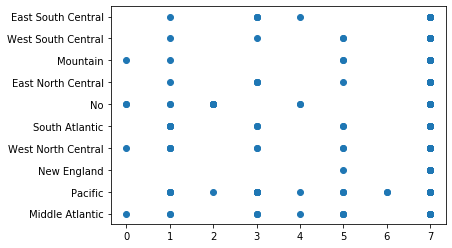

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x=X_train_encoded['Main_Dish'], y=y_train)
plt.show()

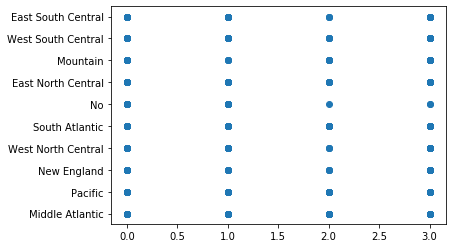

In [15]:
plt.scatter(x=X_train_encoded['Travel_Distance'], y=y_train)
plt.show()

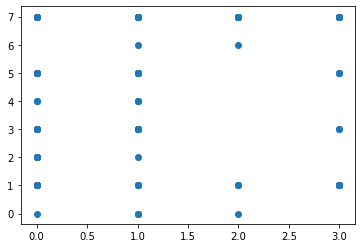

In [17]:
plt.scatter(x=X_train_encoded['Travel_Distance'], y=X_train_encoded['Main_Dish'])
plt.show()

In [11]:
#%% Logistic Regression Model

model = LogisticRegression(solver='lbfgs', max_iter = 10000, multi_class='auto')
model.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, model)
#26.6% accurate


KeyboardInterrupt: ignored

In [0]:
#%% Random Forest Model

classifier = RandomForestClassifier()
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#22.2% accurate


In [0]:
#%% those were terrible, do better! Randomized Search for hyperparameters


clf = RandomForestClassifier()
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(results['mean_test_score'][candidate], results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
#%%
# specify parameters and distributions to sample from
param_dist = {'max_depth': range(10, 50, 2),
              'min_samples_leaf': [1,2,3,4,5],'min_samples_split': [2, 3, 4, 5],
              'n_estimators': range(100, 500, 10),
              "criterion": ["gini", "entropy"]}

n_iter_search = 25
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, n_jobs=-1)

random_search.fit(X_train_encoded, y_train)

report(random_search.cv_results_)

In [0]:
#%% Grid Search for hyperparameters

param_grid = {"max_depth": range(30, 50, 5),
              "n_estimators": range(100, 500, 10),
              "min_samples_leaf": range(2, 5)
              }

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, iid=False, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
report(grid_search.cv_results_)

In [0]:
#%% this model is awful, let's try a new target
#predict whether someone will have Turkey, Ham, or something else based on other items?

train['Main_Dish'].unique()
train['Main_Dish'].value_counts(normalize=True)

#baseline = Turkey, 86.7%
#%%
target = 'Main_Dish'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)

#%%
def select_features(X_train_encoded, y_train, num_features):
    classifier = RandomForestClassifier(n_estimators=100)
    rfe_selector = RFE(estimator=classifier, n_features_to_select=num_features, step=10, verbose=5)
    rfe_selector.fit(X_train_encoded, y_train)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X_train_encoded.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature
#%%
classifier = RandomForestClassifier(n_estimators=100)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

#%% but I'd really like this to be about the food, not region or age

food = ['Stuffing', 'Cranberry_Sauce', 'Gravy', 'Brussel_Sprouts', 'Carrots', 'Cauliflower',
       'Corn', 'Cornbread', 'Fruit_Salad', 'Green_Beans', 'Mac_and_Cheese',
       'Mashed_Potatoes', 'Rolls_Biscuits', 'Squash', 'Salad',
       'Sweet_Potatoes', 'Apple_Pie', 'Buttermilk_Pie', 'Cherry_Pie',
       'Chocolate_Pie', 'Coconut_Cream_Pie', 'Key_Lime_Pie', 'Peach_Pie',
       'Pecan_Pie', 'Pumpkin_Pie', 'Sweet_Potato_Pie', 'No_Pie',
       'Apple_Cobbler', 'Blondies', 'Brownies', 'Carrot_Cake', 'Cheesecake',
       'Cookies', 'Fudge', 'Ice_Cream', 'Peach_Cobbler']
#%%
        
target = 'Main_Dish'
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
    

#%%
for column in X_train_encoded.columns:
    if column not in food:
        X_train_encoded = X_train_encoded.drop(column, axis=1)


#%%
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter = 10000)
model.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, model)
#%%

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

#%%
classifier = RandomForestClassifier(n_estimators=480, max_depth=45, min_samples_leaf=3)
features = select_features(X_train_encoded, y_train, 10)
X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)

#%%
target = 'Black_Friday_Shopper'
train['Black_Friday_Shopper'].value_counts(normalize=True)
#%%
X_train_encoded, X_test_encoded, y_train, y_test = X_y_dataframes(train, test, target)
#%%

X_train_encoded = X_train_encoded[features]
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#%%
param_grid = {"max_depth": range(30, 50, 5),
              "n_estimators": range(100, 500, 10),
              "min_samples_leaf": range(2, 5)
              }

# run grid search
grid_search = GridSearchCV(classifier, param_grid=param_grid, cv=3, iid=False, n_jobs=-1)
grid_search.fit(X_train_encoded, y_train)
report(grid_search.cv_results_)
#%%
from sklearn.metrics import precision_recall_fscore_support
y_pred_train = classifier.predict(X_train_encoded)
print(precision_recall_fscore_support(y_train, y_pred_train, average = 'weighted'))

#try gradient boosted trees!

In [0]:
#%% Random Forest Model updated


classifier = RandomForestClassifier(n_estimators = 380, min_samples_split = 4, 
                                    min_samples_leaf = 2, max_depth = 24, criterion = 'gini')
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#28.3 accuracy


#%%find features

rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators = 350, min_samples_split = 2, 
                                    min_samples_leaf = 3, max_depth = 46, criterion = 'entropy'), n_features_to_select=10, step=10, verbose=5)
rfe_selector.fit(X_train_encoded, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_encoded.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)
#%%create model just those features
features = rfe_feature

X_train_encoded = X_train_encoded[features]
X_test_encoded = X_test_encoded[features]

classifier = RandomForestClassifier(n_estimators = 460, min_samples_split = 3, 
                                    min_samples_leaf = 5, max_depth = 40, criterion = 'entropy')
classifier.fit(X_train_encoded, y_train)
loocv(X_train_encoded, y_train, classifier)
#%% other measures of "how good" my model is
from sklearn.metrics import precision_recall_fscore_support
y_pred_train = classifier.predict(X_train_encoded)
print(precision_recall_fscore_support(y_train, y_pred_train, average = 'weighted'))


In [24]:
import xgboost
model = xgboost.XGBClassifier(n_jobs=-1)
model.fit(X_train_encoded, y_train)


loocv(X_train_encoded, y_train, model)

Accuracy: 29.796% (45.736%)


In [26]:
!pip install eli5

     |████████████████████████████████| 112kB 5.1MB/s 


In [27]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC

svc = SVC().fit(X_train_encoded, y_train)
perm = PermutationImportance(svc).fit(X_train_encoded, y_train)
eli5.show_weights(perm)

Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Weight,Feature
0.0939 ± 0.0099,x42
0.0615 ± 0.0202,x51
0.0248 ± 0.0090,x0
0.0242 ± 0.0118,x1
0.0234 ± 0.0083,x48
0.0207 ± 0.0063,x49
0.0177 ± 0.0102,x3
0.0117 ± 0.0106,x40
0.0098 ± 0.0047,x2
0.0084 ± 0.0036,x10


In [28]:
X_train_encoded.iloc[:,42]

0      11.0
1       0.0
2       0.0
3       2.0
4       0.0
       ... 
730     4.0
731     2.0
732     0.0
733     0.0
734     0.0
Name: Kids_Table_Age, Length: 735, dtype: float64

In [29]:
X_train_encoded.iloc[:,51]

0      3.0
1      8.0
2      2.0
3      2.0
4      7.0
      ... 
730    0.0
731    8.0
732    2.0
733    9.0
734    6.0
Name: Household_Earnings, Length: 735, dtype: float64